In [ ]:
# Google Colab utilities
from google.colab import drive  # Importing Google Drive module for mounting

# Data manipulation
import pandas as pd  # Importing Pandas for data manipulation
import numpy as np  # Importing NumPy for numerical computations

# Data visualization
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
import seaborn as sns  # Importing Seaborn for statistical data visualization

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose  # Importing for time series decomposition
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Importing SARIMAX for SARIMA modeling
from statsmodels.tsa.stattools import adfuller  # Importing the Augmented Dickey-Fuller test for stationarity check
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Importing functions for ACF and PACF plots

# Install pmdarima
!pip install pmdarima

# Time series forecasting and differencing evaluation
from pmdarima.arima import auto_arima  # Importing auto_arima for automatic parameter selection
from pmdarima.arima.utils import ndiffs, nsdiffs  # Importing functions for differencing evaluation

# Model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error  # Importing metrics for model evaluation


Loading the dataset containing substance data from all stations.

In [54]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
df = pd.read_csv('/content/drive/MyDrive/dataset_solo_sostanze.csv')

In [22]:
print(df.head())

             From Date file_name  CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0  2016-07-01 10:00:00     AP001        0.48       17.67         39.2   
1  2016-07-01 11:00:00     AP001        0.49       20.50         41.9   
2  2016-07-01 12:00:00     AP001        0.47       15.40         43.6   
3  2016-07-01 13:00:00     AP001        0.47       15.40         43.6   
4  2016-07-01 14:00:00     AP001        0.47       15.40         43.6   

   Ozone (ug/m3)  PM10 (ug/m3)  PM2.5 (ug/m3)  SO2 (ug/m3)  \
0           14.5          39.0          10.67         6.60   
1           15.0          39.0           2.00         6.38   
2           10.5          50.0          20.50         6.38   
3           10.5          50.0          20.50         6.38   
4           10.5          50.0          20.50         6.38   

               To Date           state      city  start_month_num  start_year  
0  2016-07-01 11:00:00  Andhra Pradesh  Tirupati                7        2016  
1  2016-07-01 12:00:00  Andh

Creating a new dataframe containing only the rows with the code AP001, which identifies the station in the city of Tirupati.

In [23]:
# Define the "file_name" (station number) to filter the dataset
file_name = "AP001"

# Filter the dataframe to keep only rows where the 'file_name' column matches the specified value
df_filtered = df[df["file_name"] == file_name]

In [24]:
print(df_filtered.head(20))

              From Date file_name  CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0   2016-07-01 10:00:00     AP001        0.48       17.67        39.20   
1   2016-07-01 11:00:00     AP001        0.49       20.50        41.90   
2   2016-07-01 12:00:00     AP001        0.47       15.40        43.60   
3   2016-07-01 13:00:00     AP001        0.47       15.40        43.60   
4   2016-07-01 14:00:00     AP001        0.47       15.40        43.60   
5   2016-07-01 15:00:00     AP001        0.51       24.30        45.12   
6   2016-07-01 16:00:00     AP001        0.46       26.73        49.10   
7   2016-07-01 17:00:00     AP001        0.44       19.10        46.33   
8   2016-07-01 18:00:00     AP001        0.45       14.50        44.20   
9   2016-07-01 19:00:00     AP001        0.41       10.43        41.00   
10  2016-07-01 20:00:00     AP001        0.35        4.97        35.03   
11  2016-07-01 21:00:00     AP001        0.36        5.45        20.23   
12  2016-07-01 22:00:00     AP001     

Checking if 'From Date' is in datetime format.

In [28]:
def check_from_date_format(df):
    # Check if the 'From Date' column exists
    if 'From Date' in df.columns:
        # Check if the 'From Date' column is already in datetime format
        if pd.api.types.is_datetime64_any_dtype(df['From Date']):
            print("The 'From Date' column is already in datetime format.")
        else:
            print("The 'From Date' column is NOT in datetime format.")
    else:
        print("The 'From Date' column does not exist in the DataFrame.")

# Call the function to check the 'From Date' column format in the filtered DataFrame
check_from_date_format(df_filtered)

The 'From Date' column is NOT in datetime format.


Converting the 'From Date' column to datetime format.

In [29]:
# Convert the 'From Date' column to datetime format
df_filtered.loc[:, 'From Date'] = pd.to_datetime(df_filtered['From Date'])

Setting 'From Date' as the index and removing the column (drop=True).

In [30]:
# Set 'From Date' as the index, removing it as a column
df_filtered.set_index('From Date', inplace=True, drop=True)

# Display a preview of the data with the new structure
print(df_filtered.head())

                    file_name  CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  \
From Date                                                            
2016-07-01 10:00:00     AP001        0.48       17.67         39.2   
2016-07-01 11:00:00     AP001        0.49       20.50         41.9   
2016-07-01 12:00:00     AP001        0.47       15.40         43.6   
2016-07-01 13:00:00     AP001        0.47       15.40         43.6   
2016-07-01 14:00:00     AP001        0.47       15.40         43.6   

                     Ozone (ug/m3)  PM10 (ug/m3)  PM2.5 (ug/m3)  SO2 (ug/m3)  \
From Date                                                                      
2016-07-01 10:00:00           14.5          39.0          10.67         6.60   
2016-07-01 11:00:00           15.0          39.0           2.00         6.38   
2016-07-01 12:00:00           10.5          50.0          20.50         6.38   
2016-07-01 13:00:00           10.5          50.0          20.50         6.38   
2016-07-01 14:00:00          

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Checking if the index has been set correctly.

In [31]:
# Check the DataFrame index
print("DataFrame index:", df_filtered.index)

DataFrame index: DatetimeIndex(['2016-07-01 10:00:00', '2016-07-01 11:00:00',
               '2016-07-01 12:00:00', '2016-07-01 13:00:00',
               '2016-07-01 14:00:00', '2016-07-01 15:00:00',
               '2016-07-01 16:00:00', '2016-07-01 17:00:00',
               '2016-07-01 18:00:00', '2016-07-01 19:00:00',
               ...
               '2023-03-31 14:00:00', '2023-03-31 15:00:00',
               '2023-03-31 16:00:00', '2023-03-31 17:00:00',
               '2023-03-31 18:00:00', '2023-03-31 19:00:00',
               '2023-03-31 20:00:00', '2023-03-31 21:00:00',
               '2023-03-31 22:00:00', '2023-03-31 23:00:00'],
              dtype='datetime64[ns]', name='From Date', length=59150, freq=None)


Removing columns that are not useful for forecasting. Only substance data and the time index are needed. 'To Date' is not necessary since 'From Date' can be used as the index.

In [32]:
df_filtered = df_filtered.drop(columns=['file_name', 'To Date', 'state', 'city', 'start_month_num', 'start_year'])

# Display the first 20 rows of the filtered DataFrame
print(df_filtered.head(20))


                     CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  Ozone (ug/m3)  \
From Date                                                                 
2016-07-01 10:00:00        0.48       17.67        39.20          14.50   
2016-07-01 11:00:00        0.49       20.50        41.90          15.00   
2016-07-01 12:00:00        0.47       15.40        43.60          10.50   
2016-07-01 13:00:00        0.47       15.40        43.60          10.50   
2016-07-01 14:00:00        0.47       15.40        43.60          10.50   
2016-07-01 15:00:00        0.51       24.30        45.12           6.60   
2016-07-01 16:00:00        0.46       26.73        49.10          17.43   
2016-07-01 17:00:00        0.44       19.10        46.33          19.98   
2016-07-01 18:00:00        0.45       14.50        44.20          12.20   
2016-07-01 19:00:00        0.41       10.43        41.00          17.50   
2016-07-01 20:00:00        0.35        4.97        35.03          13.82   
2016-07-01 21:00:00      

Aggregating data on a weekly basis.

In [33]:
# Aggregating data on a weekly basis (grouping by weeks ending on Sunday)
df_filtered_weekly = df_filtered.resample('W-SUN').mean()

In [34]:
print(df_filtered_weekly.head())

            CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  Ozone (ug/m3)  PM10 (ug/m3)  \
From Date                                                                      
2016-07-03    0.705806   16.717097    42.410161      12.745645     54.078065   
2016-07-10    0.708614   14.363365    37.295621      14.352556     36.466340   
2016-07-17    0.715014   17.672602    42.750975      13.656240     43.917755   
2016-07-24    0.795035   22.620914    46.513507      14.908793     36.378164   
2016-07-31    1.056797   20.355297    49.228173      14.362200     32.531730   

            PM2.5 (ug/m3)  SO2 (ug/m3)  
From Date                               
2016-07-03      17.276774     5.237419  
2016-07-10      11.251208     5.048029  
2016-07-17      16.014783     5.310130  
2016-07-24      12.184308     4.737997  
2016-07-31      13.499298     4.959651  


Aggregating data on a monthly basis.

In [35]:
# Aggregating data on a monthly basis (grouping by the last day of each month)
df_filtered_monthly = df_filtered.resample('ME').mean()

In [36]:
print(df_filtered_monthly.head())

            CO (mg/m3)  NO (ug/m3)  NO2 (ug/m3)  Ozone (ug/m3)  PM10 (ug/m3)  \
From Date                                                                      
2016-07-31    0.809315   18.581071    43.817248      14.186968     38.738733   
2016-08-31    0.789090   19.940883    46.140234      17.639941     44.381412   
2016-09-30    0.777011   25.884927    46.536196      16.500929     38.353430   
2016-10-31    0.876883   25.914629    86.654192      15.234839     82.064028   
2016-11-30    0.913205   22.503107   102.878676      17.617874     88.251785   

            PM2.5 (ug/m3)  SO2 (ug/m3)  
From Date                               
2016-07-31      13.578600     5.032828  
2016-08-31      11.897053     5.021463  
2016-09-30      14.927469     5.318354  
2016-10-31      41.891560     6.987781  
2016-11-30      56.327434     7.467421  


Plotting the trend of the substances of interest (weekly and monthly aggregation).

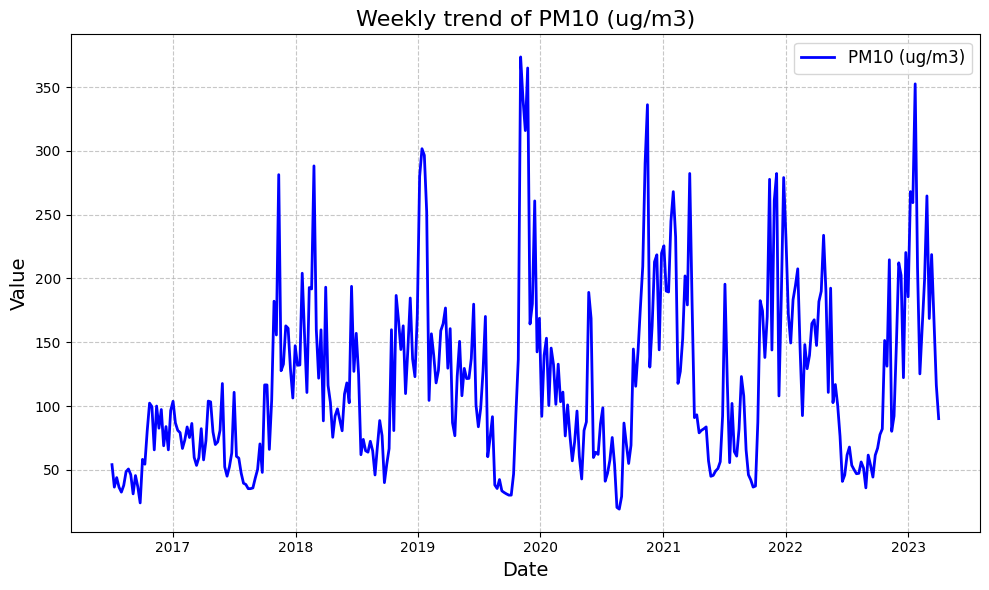

In [37]:
# Plotting the trend of the substances of interest (weekly aggregation)

substance_columns = ['PM10 (ug/m3)']

for column in substance_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered_weekly.index, df_filtered_weekly[column], label=column, color='blue', linewidth=2)
    plt.title(f'Weekly trend of {column}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# List of substance columns (complete)
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']

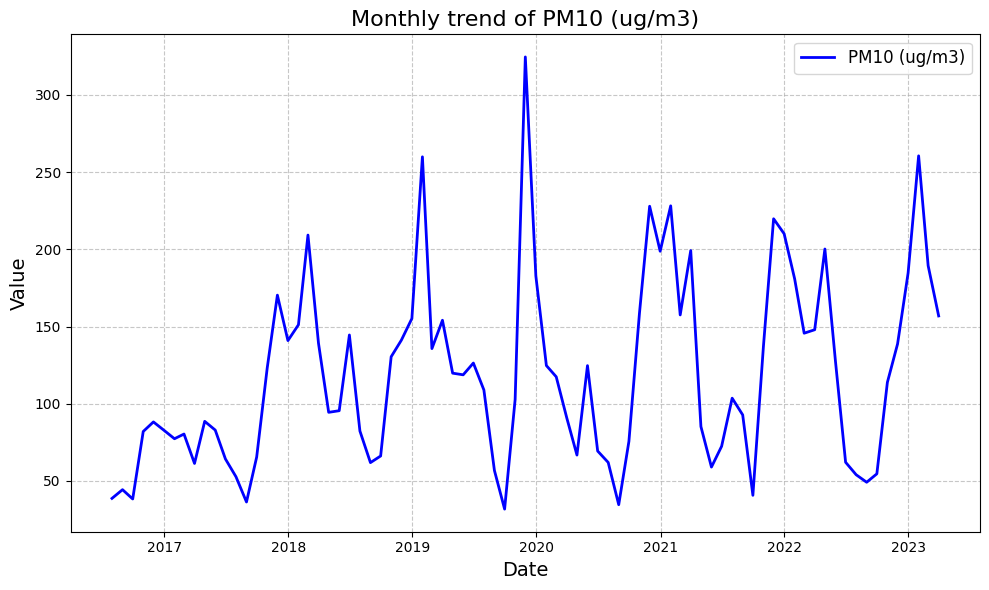

In [38]:
# Plotting the trend of the substances of interest (monthly aggreation)

substance_columns = ['PM10 (ug/m3)']

for column in substance_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered_monthly.index, df_filtered_monthly[column], label=column, color='blue', linewidth=2)
    plt.title(f'Monthly trend of {column}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# List of substance columns (complete)
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']


Decomposing to analyze trend, seasonality, and residuals (weekly trend, period = 52; monthly trend, period = 12).

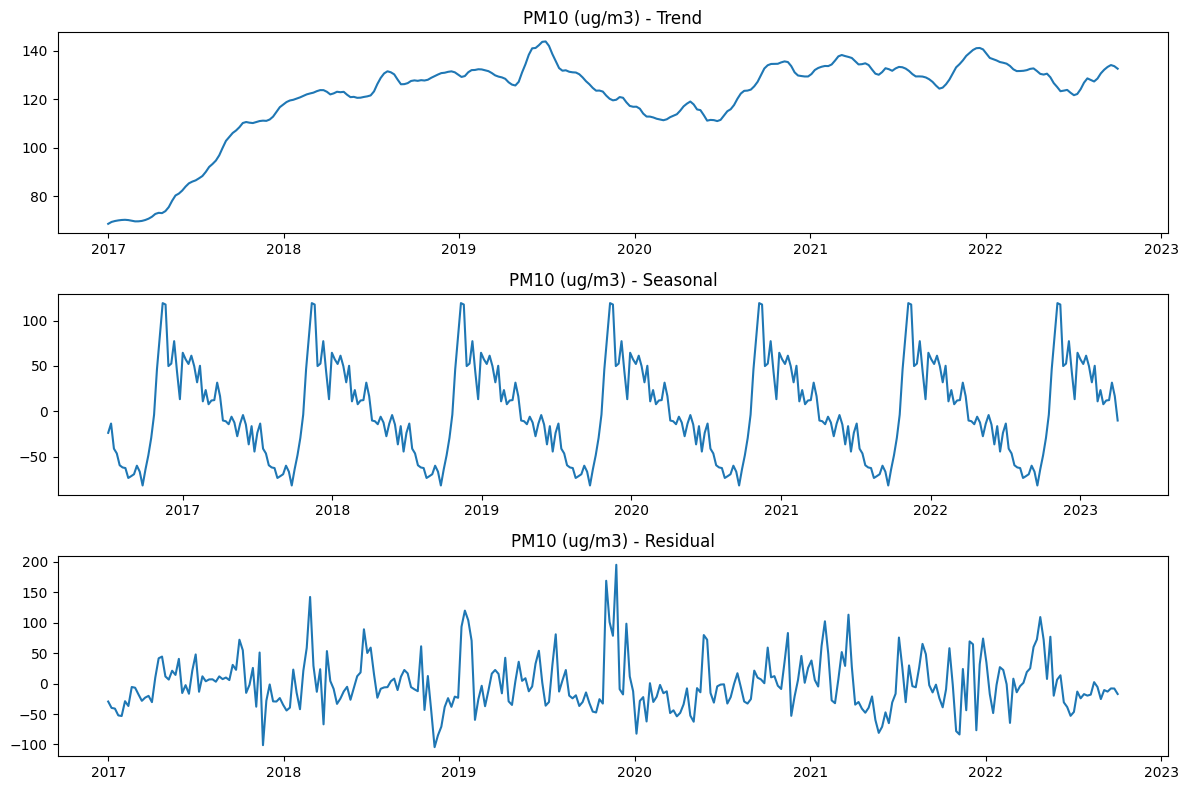

In [39]:
substance_columns = ['PM10 (ug/m3)']

for column in substance_columns:
    # Time series decomposition
    # period = 52
    decomposition = seasonal_decompose(df_filtered_weekly[column], model='additive', period=52)

    # Create a new figure for each substance
    plt.figure(figsize=(12, 8))

    # Plot the Trend component
    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend)
    plt.title(f'{column} - Trend')

    # Plot the Seasonality component
    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal)
    plt.title(f'{column} - Seasonal')

    # Plot the Residuals component
    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid)
    plt.title(f'{column} - Residual')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots for the current substance
    plt.show()

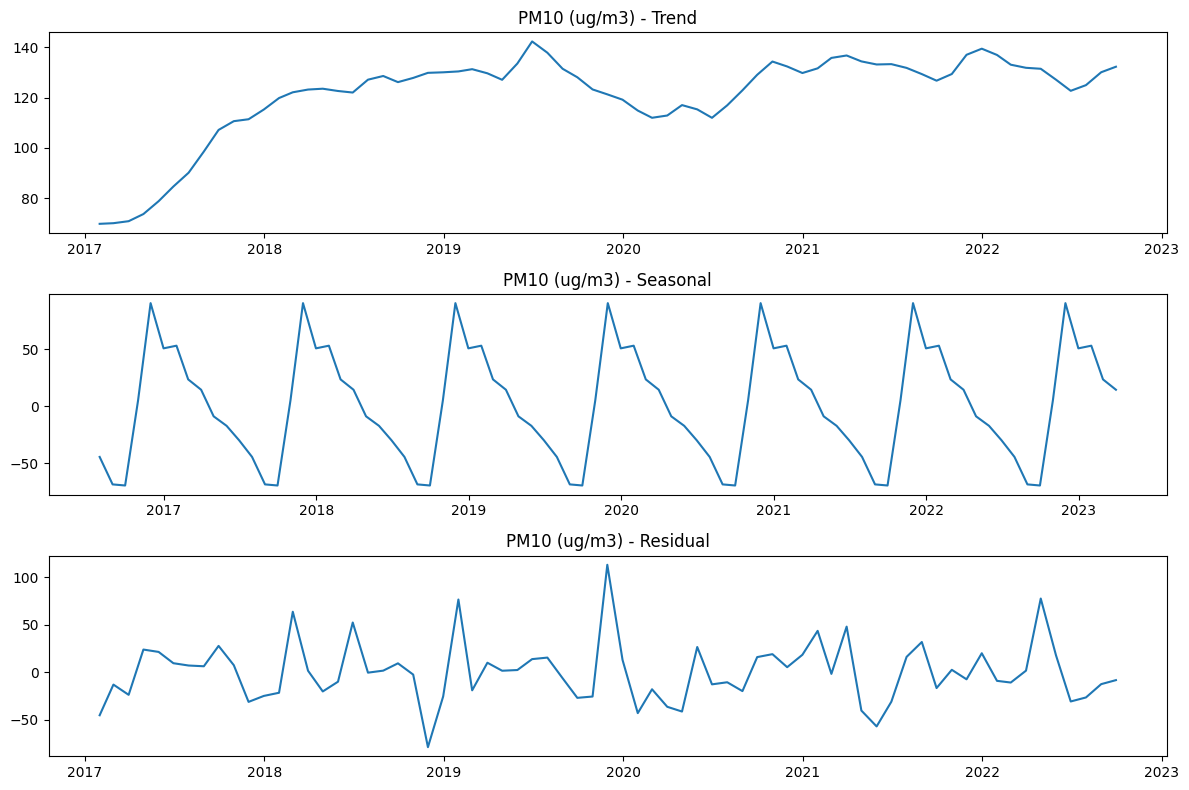

In [40]:
substance_columns = ['PM10 (ug/m3)']

for column in substance_columns:
    # Time series decomposition (additive or multiplicative model)
    # period = 12
    decomposition = seasonal_decompose(df_filtered_monthly[column], model='additive', period=12)

    # Creating a new figure for each substance
    plt.figure(figsize=(12, 8))

    # Plotting the Trend component
    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend)
    plt.title(f'{column} - Trend')

    # Plotting the Seasonality component
    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal)
    plt.title(f'{column} - Seasonal')

    # Plotting the Residuals component
    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid)
    plt.title(f'{column} - Residual')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots for the current substance
    plt.show()


Differentiating once to remove the trend and visually observe how the pattern changes.

In [41]:
# Differentiate once to remove the trend (weekly aggregation)
df_filtered_weekly_diff = df_filtered_weekly.diff()[1:]

In [42]:
# Differentiate once to remove the trend (monthly aggregation)
df_filtered_monthly_diff = df_filtered_monthly.diff()[1:]

Plotting the trend of the substance of interest after differentiation (weekly and monthly aggregation).

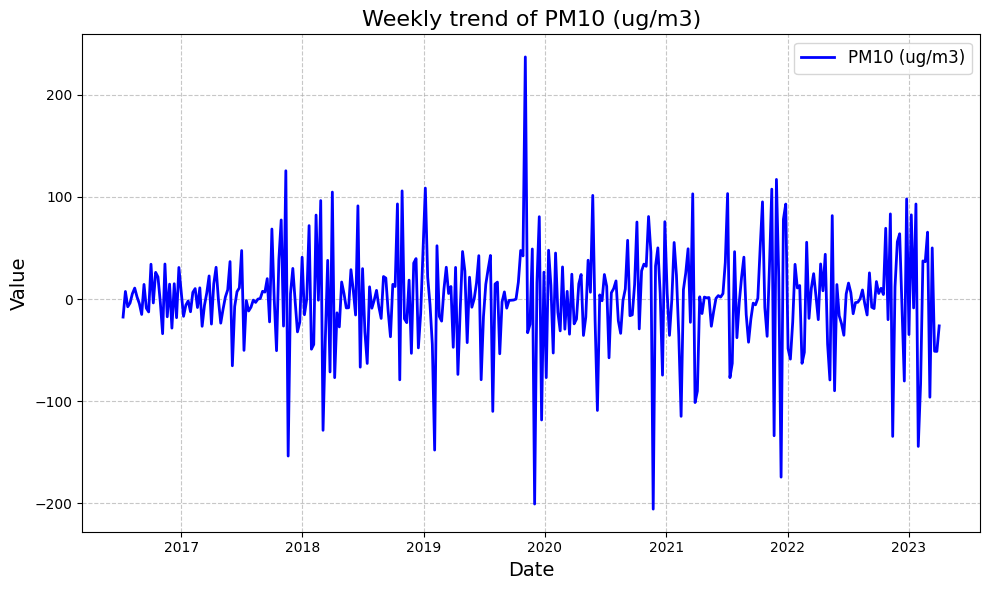

In [43]:
# List of substance columns
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']

substance_columns = ['PM10 (ug/m3)']

# Create a separate plot for each substance (weekly aggregation)
for column in substance_columns:
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(df_filtered_weekly_diff.index, df_filtered_weekly_diff[column], label=column, color='blue', linewidth=2)
    plt.title(f'Weekly trend of {column}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid style
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


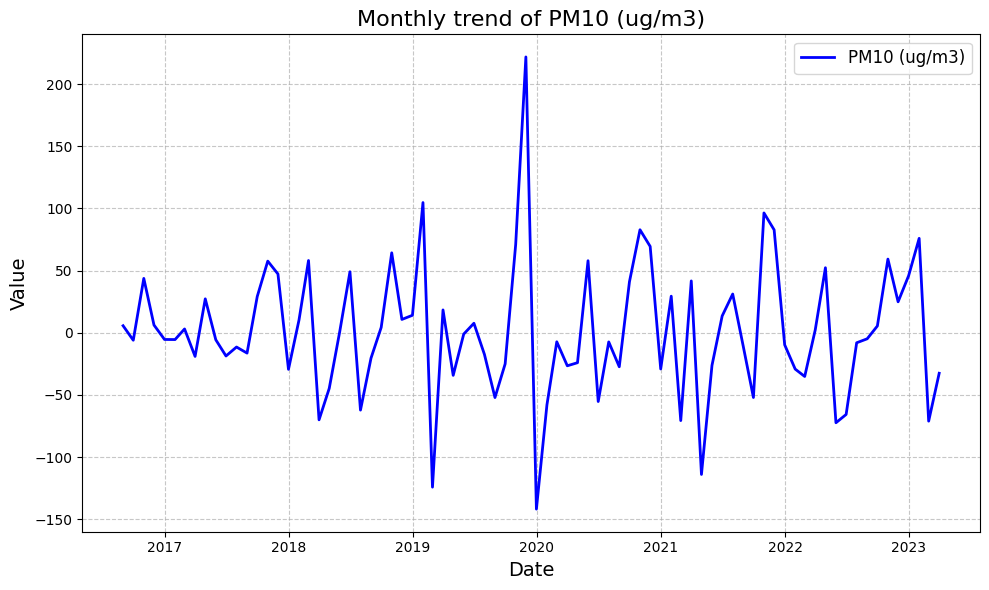

In [44]:
# List of substance columns
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']

substance_columns = ['PM10 (ug/m3)']

# Create a separate plot for each substance (monthly aggregation)
for column in substance_columns:
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(df_filtered_monthly_diff.index, df_filtered_monthly_diff[column], label=column, color='blue', linewidth=2)
    plt.title(f'Monthly trend of {column}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid style
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Computing the ADF (Augmented Dickey-Fuller) test for the substance of interest (weekly and monthly aggregation).

In [45]:
# List of substances to analyze (weekly aggregation)
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']
substance_columns = ['PM10 (ug/m3)']

# Initializing an empty list to store the results
results = []

# Performing the ADF test for each substance
for substance in substance_columns:

    # Running the ADF test on the time series with missing values removed
    result = adfuller(df_filtered_weekly[substance].dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # Storing the results in the list
    results.append({
        'Substance': substance,
        'ADF Statistic': adf_statistic,
        'p-value': p_value
    })

# Converting the results into a DataFrame for tabular representation
results_df2 = pd.DataFrame(results)

# Printing the results table
print(results_df2)



      Substance  ADF Statistic   p-value
0  PM10 (ug/m3)      -5.066981  0.000016


In [46]:
# List of substances to analyze
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']
substance_columns = ['PM10 (ug/m3)']

# Initializing an empty list to store the results
results = []

# Performing the ADF test for each substance
for substance in substance_columns:

    # Running the ADF test on the time series with missing values removed
    result = adfuller(df_filtered_monthly[substance].dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # Storing the results in the list
    results.append({
        'Substance': substance,
        'ADF Statistic': adf_statistic,
        'p-value': p_value
    })

# Converting the results into a DataFrame for tabular representation
results_df2 = pd.DataFrame(results)

# Printing the results table
print(results_df2)

      Substance  ADF Statistic   p-value
0  PM10 (ug/m3)       -3.02469  0.032652


Computing the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) for the substance of interest (weekly and monthly aggregation).

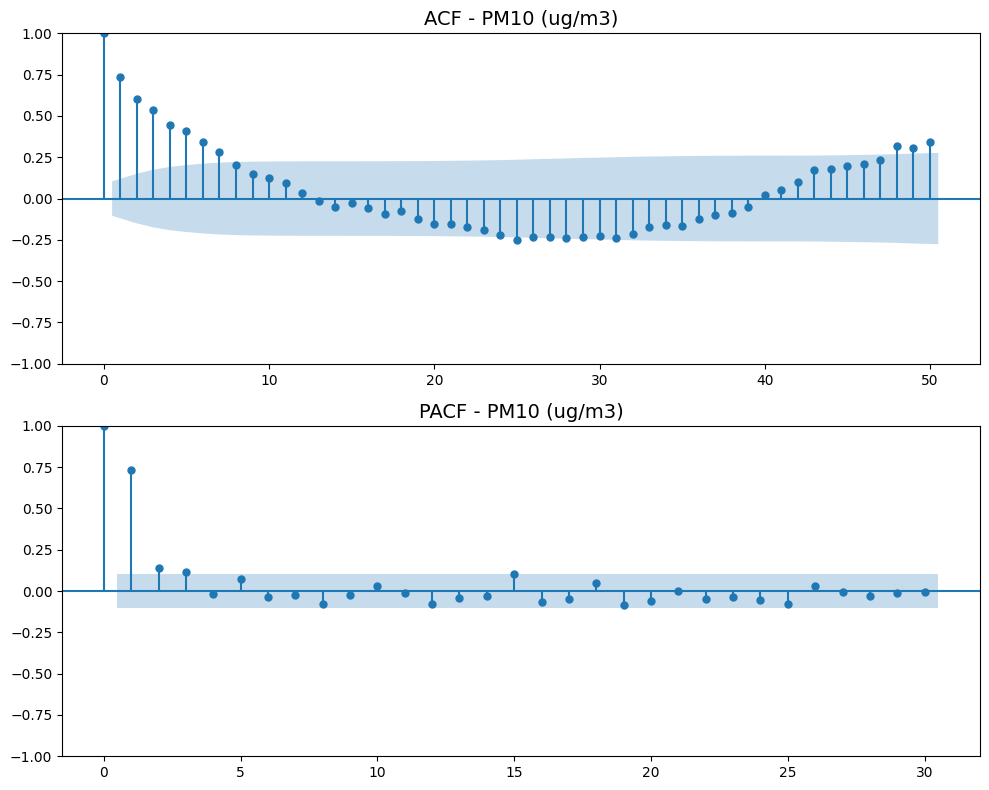

In [47]:
# List of substances
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']

substance_columns = ['PM10 (ug/m3)']

# Generating ACF and PACF plots for each substance (weekly aggregation)
for column in substance_columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating a figure with two subplots

    # ACF plot (Autocorrelation Function)
    plot_acf(df_filtered_weekly[column], lags=50, ax=axes[0])
    axes[0].set_title(f"ACF - {column}", fontsize=14)

    # PACF plot (Partial Autocorrelation Function)
    plot_pacf(df_filtered_weekly[column], lags=30, ax=axes[1])
    axes[1].set_title(f"PACF - {column}", fontsize=14)

    # Optimizing layout
    plt.tight_layout()
    plt.show()


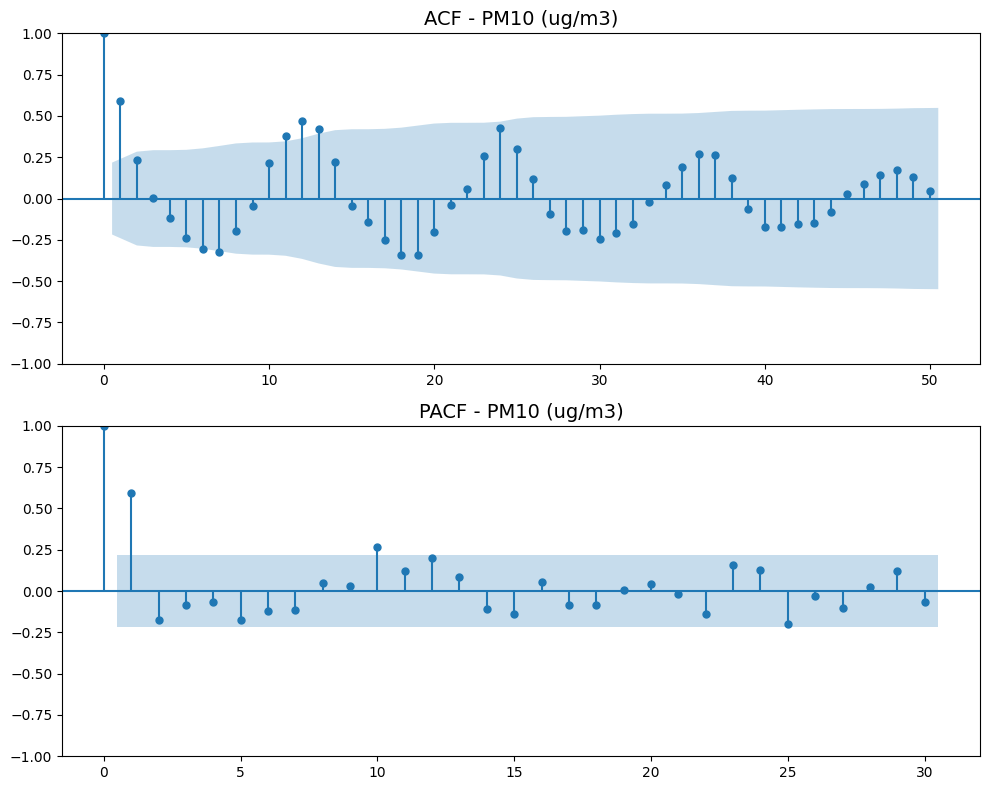

In [48]:
# List of substances
# substance_columns = ['CO (mg/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'SO2 (ug/m3)']

substance_columns = ['PM10 (ug/m3)']

# Generating ACF and PACF plots for each substance (monthly aggregation)
for column in substance_columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating a figure with two subplots

    # ACF plot (Autocorrelation Function)
    plot_acf(df_filtered_monthly[column], lags=50, ax=axes[0])
    axes[0].set_title(f"ACF - {column}", fontsize=14)

    # PACF plot (Partial Autocorrelation Function)
    plot_pacf(df_filtered_monthly[column], lags=30, ax=axes[1])
    axes[1].set_title(f"PACF - {column}", fontsize=14)

    # Optimizing layout
    plt.tight_layout()
    plt.show()

Splitting the dataset into training and test sets (weekly and monthly aggregation).

In [49]:
# Setting the split percentage for training data (weekly aggregation)
train_size = int(len(df_filtered_weekly) * 0.70)
df_filtered_weekly_train, df_filtered_weekly_test = df_filtered_weekly[:train_size], df_filtered_weekly[train_size:]

# Displaying the number of records in the training and test datasets
print("Number of records in the training dataset: " + str(len(df_filtered_weekly_train)))
print("Number of records in the test dataset: " + str(len(df_filtered_weekly_test)))

Number of records in the training dataset: 247
Number of records in the test dataset: 106


In [50]:
# Setting the split percentage for training data (monthly aggregation)
train_size = int(len(df_filtered_monthly) * 0.70)
df_filtered_monthly_train, df_filtered_monthly_test = df_filtered_monthly[:train_size], df_filtered_monthly[train_size:]

# Displaying the number of records in the training and test datasets
print("Number of records in the training dataset: " + str(len(df_filtered_monthly_train)))
print("Number of records in the test dataset: " + str(len(df_filtered_monthly_test)))

Number of records in the training dataset: 56
Number of records in the test dataset: 25


Automatic evaluation of the required differencing steps (d) and seasonal differencing steps (D) using the training dataset (weekly and monthly aggregation).

In [51]:
# Evaluation of the number of non-seasonal differencing steps (d) (weekly aggreagtion)
d = ndiffs(df_filtered_weekly_train['PM10 (ug/m3)'])

# Evaluation of the number of seasonal differencing steps (D) (weekly aggreagtion)
D = nsdiffs(df_filtered_weekly_train['PM10 (ug/m3)'], m=52)

# Display the results
print(f"Number of required differencing steps (d): {d}")
print(f"Number of required seasonal differencing steps (D): {D}")

Number of required differencing steps (d): 1
Number of required seasonal differencing steps (D): 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [52]:
# evaluation of the number of non-seasonal differencing steps (d) (monthly aggreagtion)
d = ndiffs(df_filtered_monthly['PM10 (ug/m3)'])

# evaluation of the number of seasonal differencing steps (D) (monthly aggreagtion)
D = nsdiffs(df_filtered_monthly['PM10 (ug/m3)'], m=12)

# Display the results
print(f"Number of required differencing steps (d): {d}")
print(f"Number of required seasonal differencing steps (D): {D}")

Number of required differencing steps (d): 0
Number of required seasonal differencing steps (D): 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Automatic evaluation of the optimal parameters for the SARIMA model (p, d, q, P, D, Q) using the training dataset (weekly and monthly aggregation).

In [53]:
# Automatically identify the optimal SARIMA parameters (weekly aggregation)
auto_model = auto_arima(df_filtered_weekly_train['PM10 (ug/m3)'],
                        seasonal=True,
                        m=52,  # Seasonal period
                        trace=True,  # Display detailed output
                        suppress_warnings=True)

# Display the model summary
print(auto_model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
# Automatically identify the optimal SARIMA parameters (monthly aggregation)
auto_model = auto_arima(df_filtered_monthly_train['PM10 (ug/m3)'],
                        seasonal=True,
                        m=12,  # Seasonal period
                        trace=True,  # Display detailed output
                        suppress_warnings=True)

# Display the model summary
print(auto_model.summary())

Definition and training of the SARIMA model (weekly and monthly aggregation).

In [ ]:
# Selecting the training sample for weekly aggregation
train_sample_weekly = df_filtered_weekly_train['PM10 (ug/m3)']

# Defining the SARIMA model with specified parameters
model_weekly = SARIMAX(train_sample_weekly,
                order=(2, 1, 0),  # ARIMA parameters (p, d, q)
                seasonal_order=(2, 0, 0, 52),  # Seasonal parameters (P, D, Q, s)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Training the model
results_weekly = model_weekly.fit()

# Displaying the model summary
print(results_weekly.summary())

In [ ]:
# Selecting the training sample for monthly aggregation
train_sample_monthly = df_filtered_monthly_train['PM10 (ug/m3)']

# Defining the SARIMA model with specified parameters
model_monthly = SARIMAX(train_sample_monthly,
                order=(1, 0, 1),  # ARIMA parameters (p, d, q)
                seasonal_order=(1, 0, 1, 12),  # Seasonal parameters (P, D, Q, s)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Training the model
results_monthly = model_monthly.fit()

# Displaying the model summary
print(results_monthly.summary())

Forecasting using the models, confidence intervals, calculation of Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and residual plots (weekly and monthly aggregation).

In [ ]:
# Forecasting future steps (weekly aggregation)
forecast = results_weekly.get_forecast(steps=len(df_filtered_weekly_test))

# Obtain confidence intervals
forecast_ci = forecast.conf_int()

# Forecast plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered_weekly.index, df_filtered_weekly['PM10 (ug/m3)'], label='Historical data')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast for PM10 (ug/m3)')
plt.legend()
plt.show()

# Observed and predicted values
y_true = df_filtered_weekly_test['PM10 (ug/m3)']
y_pred = forecast.predicted_mean

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"MAPE: {mape:.2%}")  # Formatted as a percentage
print(f"RMSE: {rmse:.2f}")

# Obtain predictions for the test period
forecast = results_weekly.get_forecast(steps=len(y_true))
y_pred = forecast.predicted_mean  # Predictions

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Plot comparison between actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Actual data', marker='o', color='blue')
plt.plot(y_pred.index, y_pred, label='Forecast', marker='x', color='red')

# Add titles and legends
plt.title('Comparison between actual data and forecasts')
plt.xlabel('Time')
plt.ylabel('PM10 (ug/m3)')
plt.legend()

# Display the plot
plt.show()

# Compute residuals
residuals = df_filtered_weekly_test['PM10 (ug/m3)'] - forecast.predicted_mean

# Residuals plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtered_weekly_test.index, y=residuals, label='Residuals', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Mean residuals = 0')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple', label='Residual Distribution')
plt.axvline(0, color='red', linestyle='--', label='Mean residuals = 0')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Forecasting future steps (monthly aggregation)
forecast = results_monthly.get_forecast(steps=len(df_filtered_monthly_test))

# Obtain confidence intervals
forecast_ci = forecast.conf_int()

# Forecast plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered_monthly.index, df_filtered_monthly['PM10 (ug/m3)'], label='Actual data')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast for PM10 (ug/m3)')
plt.legend()
plt.show()

# Observed and predicted values
y_true = df_filtered_monthly_test['PM10 (ug/m3)']
y_pred = forecast.predicted_mean

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"MAPE: {mape:.2%}")  # Formatted as a percentage
print(f"RMSE: {rmse:.2f}")

# Obtain predictions for the test period
forecast = results_monthly.get_forecast(steps=len(y_true))
y_pred = forecast.predicted_mean  # Predictions

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Plot comparison between actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Actual data', marker='o', color='blue')
plt.plot(y_pred.index, y_pred, label='Forecast', marker='x', color='red')

# Add titles and legends
plt.title('Comparison between actual data and forecasts')
plt.xlabel('Time')
plt.ylabel('PM10 (ug/m3)')
plt.legend()

# Display the plot
plt.show()

# Compute residuals
residuals = df_filtered_monthly_test['PM10 (ug/m3)'] - forecast.predicted_mean

# Residuals plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtered_monthly_test.index, y=residuals, label='Residuals', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Mean residuals = 0')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple', label='Residual Distribution')
plt.axvline(0, color='red', linestyle='--', label='Mean residuals = 0')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ACF plot of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=15, alpha=0.05)  # alpha=0.05 for a 95% significance threshold
plt.title('ACF of Residuals')
plt.show()

# PACF plot of residuals
plt.figure(figsize=(10, 6))
plot_pacf(residuals, lags=12, alpha=0.05, method='ywm')  # 'ywm' is robust for short datasets
plt.title('PACF of Residuals')
plt.show()